In [0]:
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils,plot_model

In [0]:
def get_notes ():
  '''estrae note e accordi dai midi files'''
  notes = []
  for f in glob.glob('midi_songs/*.mid'):
    midi = converter.parse(f)
    print (f'Elaborando {f}...')
    note_da_elaborare = None
    # dobbiamo distinguere tra strumenti e note
    try:
      # divido gli strumenti e prendo solo il primo
      parti = instrument.partitionByInstrument(midi)
      note_da_elaborare = parti.parts[0].recurse()
    except :
      # le note sono in una struttura piatta
      note_da_elaborare = midi.flat.notes
    for element in note_da_elaborare:
      if isinstance(element, note.Note):
        notes.append(str(element.pitch))
      elif isinstance(element, chord.Chord):
        notes.append('.'.join(str(n) for n in element.normalOrder))
  with open('data/notes', 'wb') as f:
    pickle.dump(notes, f)
  return notes,len(set(notes))

In [0]:
def prepara_sequenze(notes, n_vocab):
  '''Prepara le sequenza in modo che la rete neurale sia in grado di capirle'''
  lunghezza_sequenza = 100
  pitchnames = sorted(set(nota for nota in notes))
   # mappiamo le note a dei numeri
  note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

  network_input = []
  network_output = []

  # sequenza di input --> output
  for i in range(0, len(notes) - lunghezza_sequenza, 1):
      sequence_input = notes[i:i + lunghezza_sequenza]
      sequence_output = notes[i + lunghezza_sequenza]
      network_input.append([note_to_int[char] for char in sequence_input])
      network_output.append(note_to_int[sequence_output])
  n_patterns = len(network_input)
  # reshape
  network_input = numpy.reshape(network_input, (n_patterns, lunghezza_sequenza, 1))
  # normalizzazione
  network_input = network_input / float(n_vocab)
  network_output = np_utils.to_categorical(network_output)
  return network_input, network_output

In [0]:
def create_network(network_input, n_vocab):
  '''creazione rete neurale'''
  model = Sequential()
  model.add(LSTM(
      512,
      input_shape=(network_input.shape[1], network_input.shape[2]),
      recurrent_dropout=0.3,return_sequences=True
  ))
  model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
  model.add(LSTM(512))
  model.add(BatchNorm())
  model.add(Dropout(0.3))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(BatchNorm())
  model.add(Dropout(0.3))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
  return model

In [0]:
TENTATIVO = 0

In [0]:
paranoia = [ModelCheckpoint(
  "drive/My Drive/path/t:"+str(TENTATIVO)+" weights-{epoch:02d}-{loss:.4f}.hdf5",
  monitor='loss',
  verbose=0,
  save_best_only=True,
  mode='min'
  )]

In [0]:
nn_input,nn_output = prepara_sequenze(notes,n_vocab)

In [0]:
model = create_network(nn_input,n_vocab=n_vocab)

In [0]:
model.load_weights('se ci sono dei dati pre-trainati metterli qui')

In [0]:
model.fit(nn_input, nn_output, epochs=200, batch_size=128, callbacks=paranoia)

In [0]:
model.save_weights("drive/My Drive/path/t:"+str(TENTATIVO)+" weights.hdf5")

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 512)          1052672   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)              

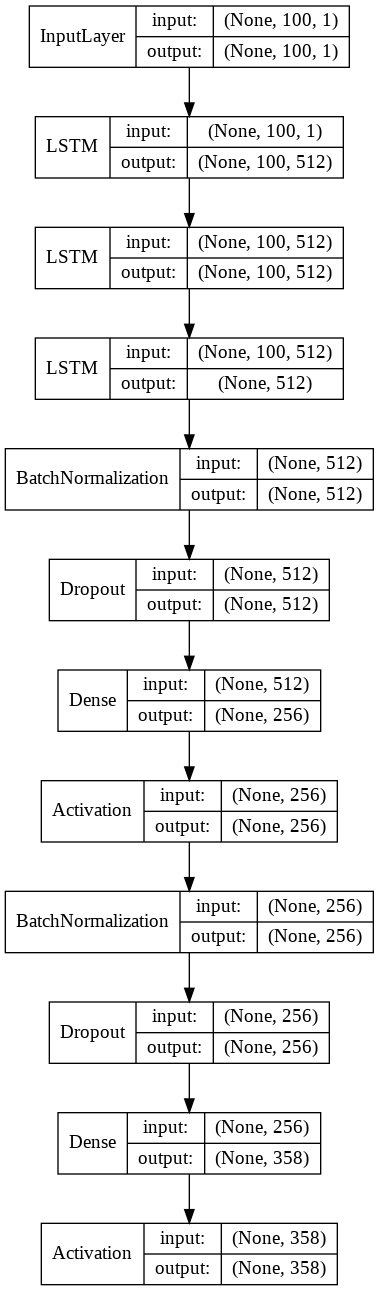

In [0]:
plot_model (model,"nn model no name.png",show_shapes = True,show_layer_names=False)